# simulation of PSF smearing correction maps and test run 
- Creating ring as in Ma+2023 and convolving with observed PSF, calculating the 'correction matrix' f for different PSF size (filters) and cuts of the PSF image. 
- also calculating correction matrix for the elliptical ring with 

    
We have to equal all <0 values in qphi to 0 because in the analysis process data we focus only on qphi>=0. This values corerspond to the azimutal polarisation and also deconvolution work only for the >0.

The PSF smearing is based on the corresponding observational PSF for the each target and each corresponding camera

Initial functions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
import pandas as pd
from PIL import Image, ImageChops
import sys
import math
import seaborn as sns
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.modeling.models import Lorentz1D
from astropy.convolution import convolve_fft
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
import functions as f
import textwrap

In [2]:
def deconvolving(image, psf, N_decon):
    psf_flipped=np.flip(psf)                                                    # due to Richardson-Lucy deconvolution method
    decon = np.copy(image)                                                      # create starting file for first iteration of deconvolution.  For the very first step, we use the original file as it’s own deconvolution
    for i in range(0, N_decon):                                                 # now iterate

        print ('deconvolution step ' + str(i))                                          # just some control output

        image_safe = np.nan_to_num(image, nan=0.0, posinf=0, neginf=0)
        decon_safe = np.nan_to_num(decon, nan=0.0, posinf=0, neginf=0)

        decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))

        # decon = decon*(convolve_fft(image / convolve_fft(decon, psf), psf_flipped))     # performs a convolution of the current decon image w/ Fourier Transform

        # the following loop checks whether the convolution process has converged
        if i==0:
            deconvolved1=decon
            crit=1
        if i>=1:
            crit=compare(decon,deconvolved1)
            deconvolved1=decon
        if (crit<0.015):
            N_final=i
            print(N_final)
            break

    return decon, crit

def plot_with_same_color(data, keys, labels, title, star, lim1, arcsinh, cameras):
    # min and max values set manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key])
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout

    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].min() for key in keys)
    vmax =max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].max() for key in keys)

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6

        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, d, -d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        levels=[np.max(data_arcshin[key])/4,np.max(data_arcshin[key])/2]
        #CS=ax.contour(data_arcshin[key], levels=levels,colors=['pink','white'], extent=(-d, d, d, -d))
        #ax.clabel(CS, inline=True, fontsize=10)
        wrapped_title = "\n".join(textwrap.wrap(labels[key], width=25))
        ax.set_title(wrapped_title)
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    specific_folder=figfolder+'models/'
    try:
    #Create target Directory
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")

    plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*1/rng #normalised to [0,1]

def compare(img1, img2):
    # normalize to compensate for exposure difference

    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))/np.sum(img1)

    return m_norm

def Loadimages_other(ifile):

    dir =dirdat_model
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            imageItot = hduli[0].data[0]
            imageQ = hduli[0].data[1]
            imageU = hduli[0].data[2]
            imageI = hduli[0].data[3]

            n = imageQ.shape[0]

    return imageItot, imageQ,imageU,imageI, n, hduli

def Loadimages(star,fittype):
#This function downloads fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir = dirdat + star + '/IRDIS/2019/2.0/reduced_pdi/star_pol_subtr/'

    # if star=='u_mon_combined':
    #     dir =dirdat + star + '/reduced_pdi_combined/star_pol_subtr/' #for combined set

    if fittype=='I_tot':
        ifile = '*I_tot.fits'
    else:
        ifile = '*'+fittype+'_star_pol_subtr.fits'
    psfile = '*I_tot.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            #image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']

    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSF = hdulPSF['Primary'].data

    return image, PSF,n,hduli

def plotImage(image1, lim1,ps):
    n = image1.shape[0]

    fig, ax = plt.subplots()
    image = image1#np.arcsinh(image1)#np.copy(image1)#
    if ps==12.27:
        lim=lim1*1.0
    else:
        lim=lim1*12.27/3.6
    max = np.max(image[int(n/2-2*lim/2):int(n/2+2*lim/2),int(n/2-2*lim/2):int(n/2+2*lim/2)])
    min=np.min(image[int(n/2-2*lim/2):int(n/2+2*lim/2),int(n/2-2*lim/2):int(n/2+2*lim/2)])
    d = n * ps / 2
    #plt.imshow(image, extent=(-d, d, d, -d))
    plt.imshow(image,vmin=min, vmax=max, extent=(-d, d, d, -d))
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout(pad=3.0)
    plt.show()
    plt.close()

def Loadimage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

    return fit

def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    return dirname

 ## Folder settings

In [47]:

stars=['01.SCI_AR_Pup','REF_HD74128','02.SCI_AR_Pup','REF_HD75885','REF_HD71253','01.SCI_UMon','HD96314','HD98025']
starnames={'REF_HD74128':'HD74128','REF_HD71253':'HD71253','01.SCI_UMon':'UMon','REF_HD75885':'HD75885','01.SCI_AR_Pup':'AR Pup','02.SCI_AR_Pup':'AR Pup'}
#stars=['HD71253','HD96314']
#disk_incl_pa={'AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
sci_of_ref={'REF_HD75885':'01.SCI_AR_Pup','01.SCI_UMon':'01.SCI_UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226','REF_HD74128':'02.SCI_AR_Pup'} #the corresponding scientific targets, SPHERE proposals
irdis_of_ref={'01.SCI_UMon':'01.SCI_UMon','HD96314':'hr4049'} #the corresponding scientific targets, SPHERE proposals

disk_incl_pa={'01.SCI_AR_Pup':[75,45],'01.SCI_UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1],'02.SCI_AR_Pup':[75,45]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

star=stars[5]
#
# if star=='01.SCI_UMon' or star=='HD96314':
#     bands=['H']
# else:
#     bands=['V','I']
# bands=['H']
bands=['V','I','H']

# create_dir(figfolder+star+'/')

#fittypes=['I_pol','Q_phi']

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/'
create_dir(figfolder)


N_decon = 20

dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'


In [48]:
PDI = None
DI = None

In [49]:
PDI = True

In [50]:
star

'01.SCI_UMon'

## Creating 1-pixel width ring and convolving with observational PSF for V,I bands
Checking for different cut of the PSF array
Resulting array of correcting coef is saved to fits files

In [51]:
if PDI == True:

    # initialise
    ring_H=np.zeros((1024,1024))
    f_pi_i=np.ones((1024,1024))
    f_pi_v=np.ones((1024,1024))
    f_pi_h=np.ones((1024,1024))
    f_q_i=np.ones((1024,1024))
    f_q_v=np.ones((1024,1024))
    f_q_h=np.ones((1024,1024))

    # create grid
    n_model=1024
    shift=int((n_model)/2.)
    x = np.linspace(-shift+1, shift, num=n_model)
    y = np.linspace(-shift+1, shift, num=n_model)
    x=x-0.5
    y=y-0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # calculating angle for azimuthal polarisation
    phi= np.arctan(Y/X)

    dataframes={}

    #[30,40,50,60,70,80,90,100,150,200]
    #
    for psf_cut in [50]:#,50,90]:
        print(psf_cut)
        # downloading PSF files (IRDIS)
        if star=='01.SCI_UMon' or star=='HD96314':
            image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
            psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
            psf_H=psf_H_short#/np.sum(psf_H_short)

        # load ZIMPOL processed data
        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

        # load I and V band data
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        n=psf_I.shape[0]
        # crop image to centre
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # normalise the image (optional)
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)
        #
        # figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/' # IRDAP_Reduced/reduced_pdi/star_pol_subtr/'
        # _, psf_H1, _, _=Loadimages(star,'I_tot') #star+'_'+'H'+'_'+'I'+'
        # psf_H_short=psf_H1[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # psf_H = psf_H_short

        # create a data frame
        df = pd.DataFrame(columns=['radius_pix','radius_H', 'sum_Qphi_H','sum_Uphi_H','f_H','radius_V',  'sum_Qphi_V','sum_Uphi_V','f_V','radius_I','sum_Qphi_I','sum_Uphi_I','f_I'])
        index=-1

        # for inner radius
        for radius in range(2,150,1):
            df.empty
            index=index+1
            ring_H=np.zeros((1024,1024))

            # create a mask
            ring_H[(R<=radius)*(R>radius-1)]=1
            print(ring_H)
            df.loc[index,'radius_pix']=radius

            # calculate Q and U projections
            ring_H_q=ring_H*np.cos(2*phi)
            ring_H_u=ring_H*np.sin(2*phi)

            lim=20

            # qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
            # uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot

            # define band pixel/mas
            for band in bands:
                if band=='I':
                    ps=3.6
                    psf=psf_I
                elif band=='V':
                    ps=3.6
                    psf=psf_V
                elif band=='H':
                    ps=12.27
                    psf=psf_H

               # perform convolution

                # Q & U Stokes
                Q_conv=convolve_fft(ring_H_q, psf, boundary='wrap')#, normalize_kernel=np.sum)
                U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)

                # Q_phi and U_phi
                Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
                # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16
                U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

                q_phi_sum = np.sum(Q_phi_conv)
                print(f"Radius: {radius}, sum(Q_phi_conv): {q_phi_sum}")

                #print('Q_phi',np.sum(Q_phi_conv))
                df.loc[index,'sum_Qphi_'+band]=np.sum(Q_phi_conv)
                df.loc[index,'radius_'+band]=radius*ps

                df.loc[index,'sum_Uphi_'+band]=np.sum(U_phi_conv)
                df.loc[index,'f_'+band]=np.sum(ring_H)/np.sum(Q_phi_conv)
                dataframes[f'df_{psf_cut}'] = df

                if band=='I':
                    f_q_i[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                    f_pi_i[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='V':
                    f_q_v[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                    f_pi_v[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='H':
                    f_q_h[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                    f_pi_h[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))

        # convert
        df.to_csv(figfolder+f'df_{psf_cut}'+'.csv')

        # save to fits file
        #
        out_fits = fits.HDUList(fits.PrimaryHDU(f_q_i))                  # create output fits structure
        out_fits.writeto(figfolder+'Iband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        out_fits = fits.HDUList(fits.PrimaryHDU(f_q_v))                  # create output fits structure
        out_fits.writeto(figfolder+'Vband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        # out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))
        # out_fits.writeto(figfolder+'Hband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)
        #
        if star=='01.SCI_UMon' or star=='HD96314':
            print(band)
            out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))                  # create output fits structure
            out_fits.writeto(figfolder+'Hband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                   # write output
        #
        out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_i))                  # create output fits structure
        out_fits.writeto(figfolder+'Iband_pi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

        out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_v))                  # create output fits structure
        out_fits.writeto(figfolder+'Vband_pi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        #
        if star=='01.SCI_UMon' or star=='HD96314':
            out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_h))                  # create output fits structure
            out_fits.writeto(figfolder+'Hband_pi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

50
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Radius: 2, sum(Q_phi_conv): 0.2641646667647326
Radius: 2, sum(Q_phi_conv): 0.2952018815439084
Radius: 2, sum(Q_phi_conv): 1.2034466881992263
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Radius: 3, sum(Q_phi_conv): 1.6703111523247431
Radius: 3, sum(Q_phi_conv): 1.889553922582966
Radius: 3, sum(Q_phi_conv): 6.600059435412667
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Radius: 4, sum(Q_phi_conv): 2.918660643422294
Radius: 4, sum(Q_phi_conv): 3.3386892697801533
Radius: 4, sum(Q_phi_conv): 9.688070642920048
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 

In [52]:
star

'01.SCI_UMon'

In [53]:
# DI = True

In [54]:
if DI == True:

    # initialise
    ring_H=np.zeros((1024,1024))
    f_i_i=np.ones((1024,1024))
    f_i_v=np.ones((1024,1024))
    f_i_h=np.ones((1024,1024))

    # create grid
    n_model=1024
    shift=int((n_model)/2.)
    x = np.linspace(-shift+1, shift, num=n_model)
    y = np.linspace(-shift+1, shift, num=n_model)
    x=x-0.5
    y=y-0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    #calculating angle for azimuthal polarisation
    # phi= np.arctan(Y/X)

    dataframes={}

    #[30,40,50,60,70,80,90,100,150,200]
    #
    for psf_cut in [50]:#,50,90]:
        print(psf_cut)
        # # downloading PSF files (IRDIS)
        if star=='01.SCI_UMon' or star=='HD96314':
            image_sphere, psf_H, n,hdul= Loadimages(star,'I_tot')
            psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
            psf_H=psf_H_short#/np.sum(psf_H_short)

        # load ZIMPOL processed data
        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/'

        # load I and V band data
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        n=psf_I.shape[0]
        # crop image to centre
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # normalise the image (optional)
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)
        #
        # figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/' # IRDAP_Reduced/reduced_pdi/star_pol_subtr/'
        # _, psf_H1, _, _=Loadimages(star,'I_tot') #star+'_'+'H'+'_'+'I'+'
        # psf_H_short=psf_H1[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # psf_H = psf_H_short

        # create a data frame
        df = pd.DataFrame(columns=['radius_pix','radius_H', 'sum_I_H','f_H','radius_V', 'sum_I_V','f_V','radius_I','sum_I_I','sum_Uphi_I','f_I'])
        index=-1

        # for inner radius
        for radius in range(2,200,1):
            df.empty
            index=index+1
            ring_H=np.zeros((1024,1024))

            # create a mask
            ring_H[(R<=radius)*(R>radius-1)]=1
            print(ring_H)
            df.loc[index,'radius_pix']=radius

            # calculate Q and U projections
            # ring_H_q=ring_H*np.cos(2*phi)
            # ring_H_u=ring_H*np.sin(2*phi)

            lim=20

            # qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
            # uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot

            # define band pixel/mas
            for band in bands:
                if band=='I':
                    ps=6.8
                    psf=psf_I
                elif band=='V':
                    ps=6.8
                    psf=psf_V
                elif band=='H':
                    ps=12.27
                    psf=psf_H

               # perform convolution

                # Q & U Stokes
                I_conv=convolve_fft(ring_H, psf, boundary='wrap', normalize_kernel=np.sum)

                # Q_phi and U_phi
                # Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
                # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16
                # U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

                # q_phi_sum = np.sum(Q_phi_conv)
                # print(f"Radius: {radius}, sum(Q_phi_conv): {q_phi_sum}")

                #print('Q_phi',np.sum(Q_phi_conv))
                # df.loc[index,'sum_Qphi_'+band]=np.sum(Q_phi_conv)
                df.loc[index,'radius_'+band]=radius*ps

                df.loc[index,'sum_I_'+band]=np.sum(I_conv)
                df.loc[index,'f_'+band]=np.sum(ring_H)/np.sum(I_conv)
                # dataframes[f'df_{psf_cut}'] = df

                if band=='I':
                    f_i_i[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(I_conv)
                    # f_i_i=np.sum(ring_H)/np.sum(I_conv)
                    # f_pi_i[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='V':
                    f_i_v[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(I_conv)
                    # f_i_v=np.sum(ring_H)/np.sum(I_conv)
                    # f_pi_v[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))

                elif band=='H':
                    f_i_h[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                    # f_i_h=np.sum(ring_H)/np.sum(Q_phi_conv)
                    # f_pi_h[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))

        # convert
        df.to_csv(figfolder+f'df_{psf_cut}'+'.csv')

        # save to fits file
        #
        out_fits = fits.HDUList(fits.PrimaryHDU(f_i_i))                  # create output fits structure
        out_fits.writeto(figfolder+'Iband_i_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        out_fits = fits.HDUList(fits.PrimaryHDU(f_i_v))                  # create output fits structure
        out_fits.writeto(figfolder+'Vband_i_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        # out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))
        # out_fits.writeto(figfolder+'Hband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)
        #
        # if star=='01.SCI_UMon' or star=='HD96314':
        #     print(band)
        #     out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))                  # create output fits structure
        #     out_fits.writeto(figfolder+'Hband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                   # write output
        #

TypeError: Image data of dtype object cannot be converted to float

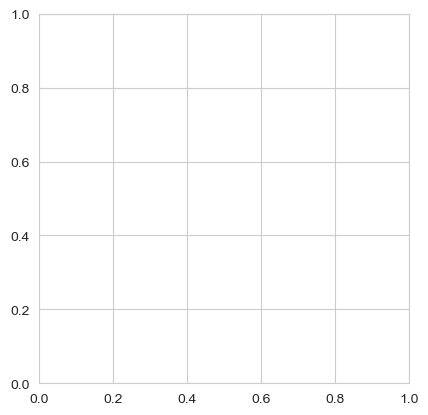

In [55]:
plt.imshow(out_fits)

In [40]:
plt.imshow(f_i_v)

NameError: name 'f_i_v' is not defined

In [56]:
plt.imshow(f_i_i)

NameError: name 'f_i_i' is not defined

In [57]:
ring_H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1024, 1024))

In [58]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/'

## Plotting radial dependence of the correcting coef for different filters and cuts

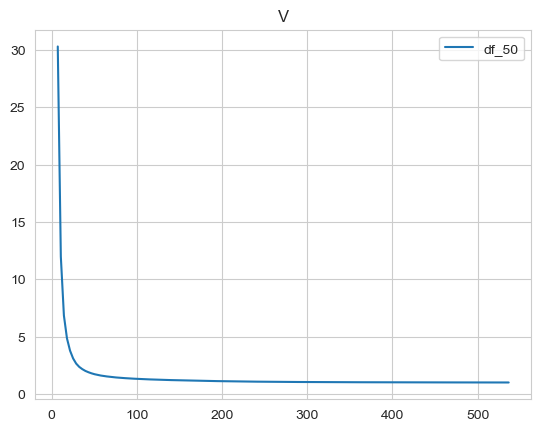

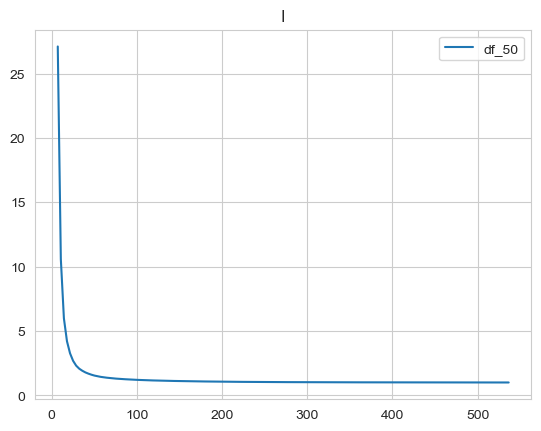

In [59]:
#df=dataframes['df_30']
dataframes={}

#
for psf_cut in [50]:
    dataframes[f'df_{psf_cut}'] = pd.read_csv(figfolder+f'df_{psf_cut}'+'.csv')

# # plot radius v H band
# for key,df in dataframes.items():
#     plt.plot(df['radius_H'],df['f_H'],label=key)
#     plt.title('H')
#     # plt.ylim(0,10)
#     # plt.xlim(10,600)
#     plt.legend()
# plt.show()
# plt.close()

# plot radius v V band
for key,df in dataframes.items():
    plt.plot(df['radius_V'],df['f_V'],label=key)
    plt.title('V')
    # plt.ylim(0,10)
    # plt.xlim(10,600)
    plt.legend()
plt.show()
plt.close()

# plot radius v I band
for key,df in dataframes.items():
    plt.plot(df['radius_I'],df['f_I'],label=key)
    plt.title('I')
    # plt.ylim(0,10)
    # plt.xlim(10,600)
    plt.legend()
plt.show()
plt.close()

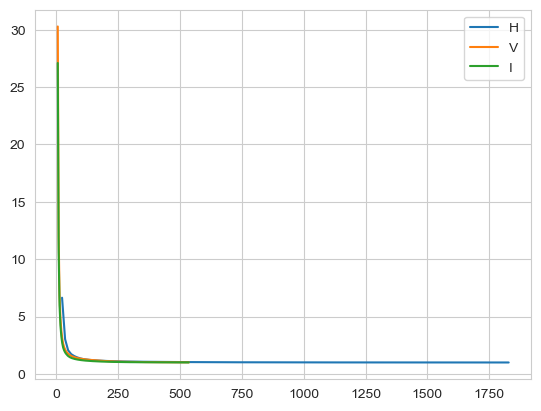

In [60]:
# plot all three bands
#df=dataframes['df_30']
#plt.plot(df['radius_H'],df['f_H'],label='df_30')
key='df_50'
df=dataframes[key]
plt.plot(df['radius_H'],df['f_H'],label='H')
plt.plot(df['radius_V'],df['f_V'],label='V')
plt.plot(df['radius_I'],df['f_I'],label='I')
# plt.ylim(0,10)
# plt.xlim(10,600)
plt.legend()

## Simulating 'face-on' disk and testing the correction
convolution -> deconvolution -> PSF smearing correction

50
V


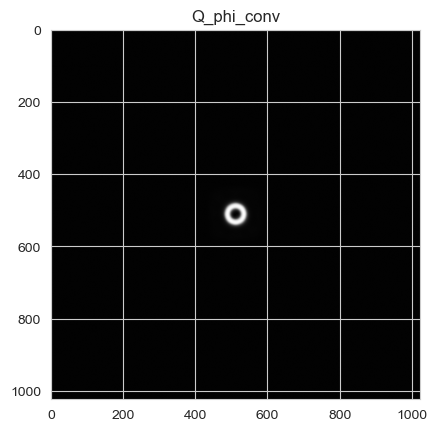

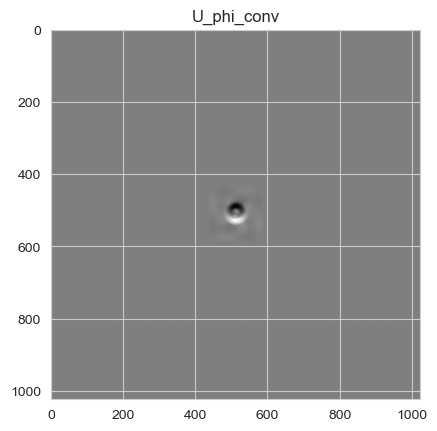

deconvolution step 0


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_79801/1453654390.py:11: RuntimeWarning: divide by zero encountered in divide
  decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_79801/1453654390.py:11: RuntimeWarning: invalid value encountered in divide
  decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))


deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
9
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
9
0.013852455553814117


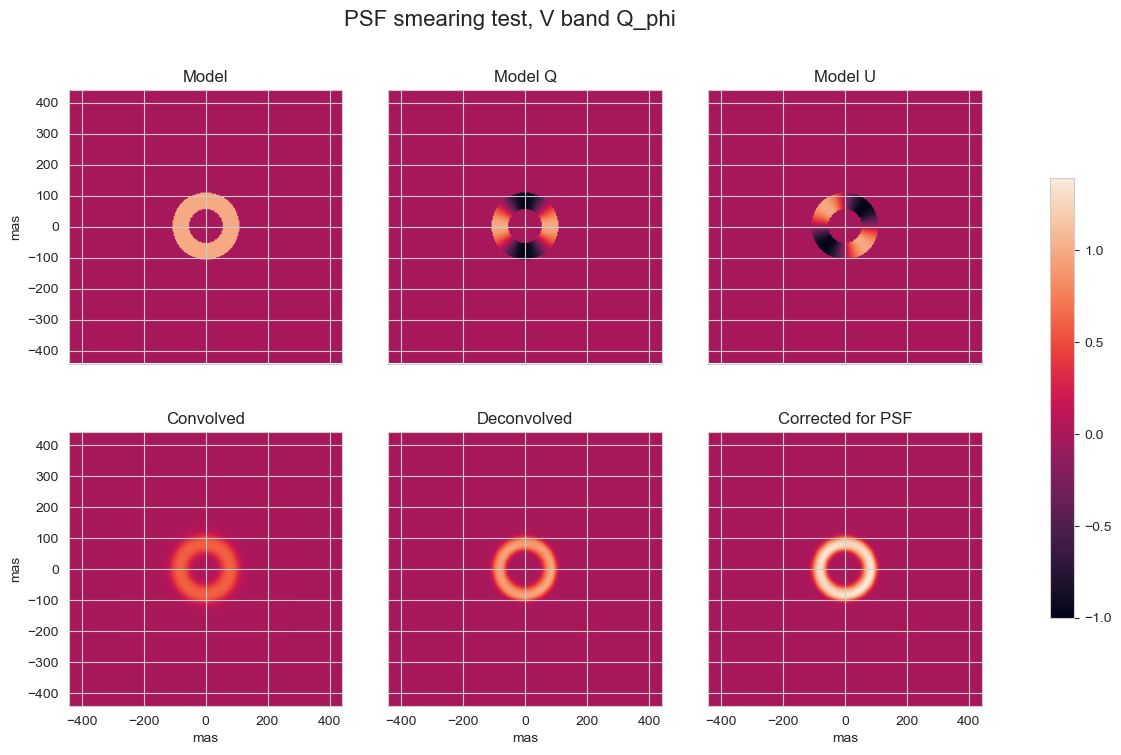

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.7111867893508993
Correction efficion  1.0010921451456556
sum_PI
Signal after PSF convolution (as ratio to initial) 0.7154779607525423
PI corr  [[-1.12684474e-21 -1.72825436e-20 -6.69928212e-20 ... -7.80589541e-21
  -2.72831848e-21  4.00478954e-22]
 [-1.70570197e-21 -3.60003118e-20 -1.44098700e-19 ... -2.12427404e-20
   1.81448460e-21  4.00186052e-21]
 [-1.27803261e-21 -4.25145568e-20 -1.77628069e-19 ...  1.25221809e-20
   4.06645360e-20  1.15508040e-20]
 ...
 [ 2.80020746e-21  3.25650932e-20  1.78297570e-20 ...  2.72141556e-20
   1.24924616e-20  3.58554029e-21]
 [ 2.27425447e-22  1.09771543e-21 -1.50370168e-20 ...  6.64178779e-21
   3.33032764e-21  1.00710586e-21]
 [-5.76199666e-24 -2.50256660e-22 -1.73844458e-21 ...  1.08381609e-21
   5.90577974e-22  1.91545452e-22]]
Correction efficion  0.9990748403399232
I


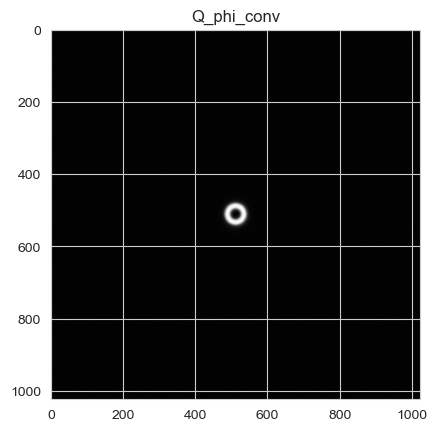

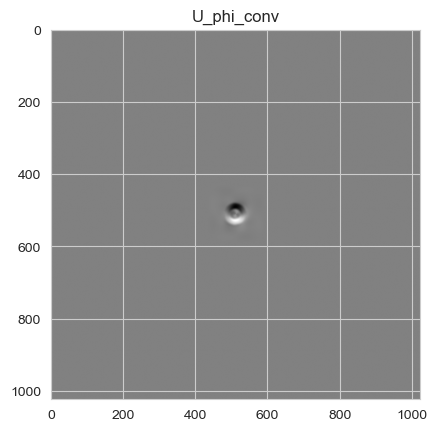

deconvolution step 0


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_79801/1453654390.py:11: RuntimeWarning: divide by zero encountered in divide
  decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_79801/1453654390.py:11: RuntimeWarning: invalid value encountered in divide
  decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))


deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
8
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
8
0.014393241747881468
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/models/  already exists


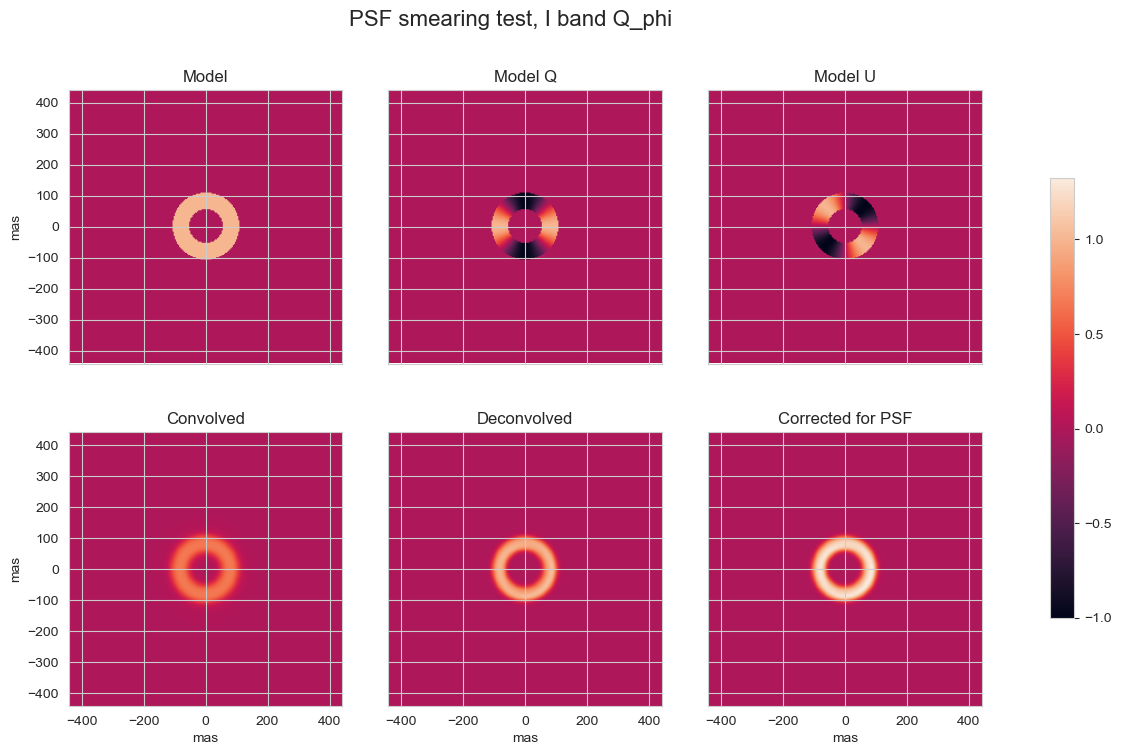

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.7860633284119807
Correction efficion  1.0005939034281373
sum_PI
Signal after PSF convolution (as ratio to initial) 0.7880879602660351
PI corr  [[-2.38281152e-21 -1.13549236e-20 -8.52656066e-20 ...  9.80714296e-20
   9.80615492e-20  1.76291557e-21]
 [-5.71771720e-21 -3.14920367e-20 -2.37136243e-19 ...  7.23604011e-19
   6.64305577e-19  1.21748568e-20]
 [-7.20789914e-21 -4.53341296e-20 -3.58301590e-19 ...  2.23318119e-18
   2.11747250e-18  3.81474909e-20]
 ...
 [-9.61727791e-21 -2.52394075e-20 -2.26079733e-19 ... -4.61567434e-16
  -7.77751264e-16 -1.62170773e-17]
 [-1.71070135e-21 -5.11582251e-21 -4.37630810e-20 ... -2.19370723e-16
  -3.48922448e-16 -8.15911476e-18]
 [-1.91017401e-22 -6.57423145e-22 -5.81542658e-21 ... -4.39996984e-17
  -6.47902249e-17 -1.70595982e-18]]
Correction efficion  0.9995868278936879
H


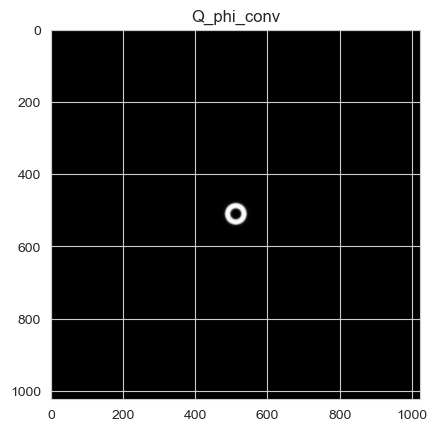

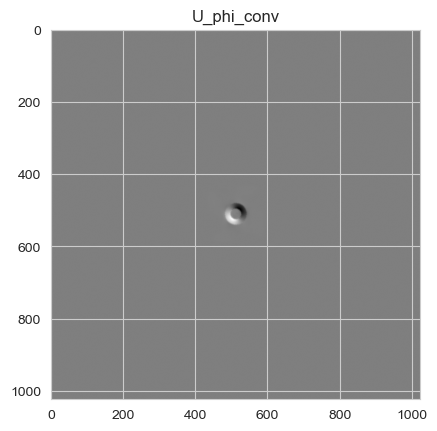

deconvolution step 0


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_79801/1453654390.py:11: RuntimeWarning: divide by zero encountered in divide
  decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_79801/1453654390.py:11: RuntimeWarning: invalid value encountered in divide
  decon = decon_safe * (convolve_fft(image_safe / convolve_fft(decon_safe, psf), psf_flipped))


deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
10
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
10
0.014271614070198292
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/models/  already exists


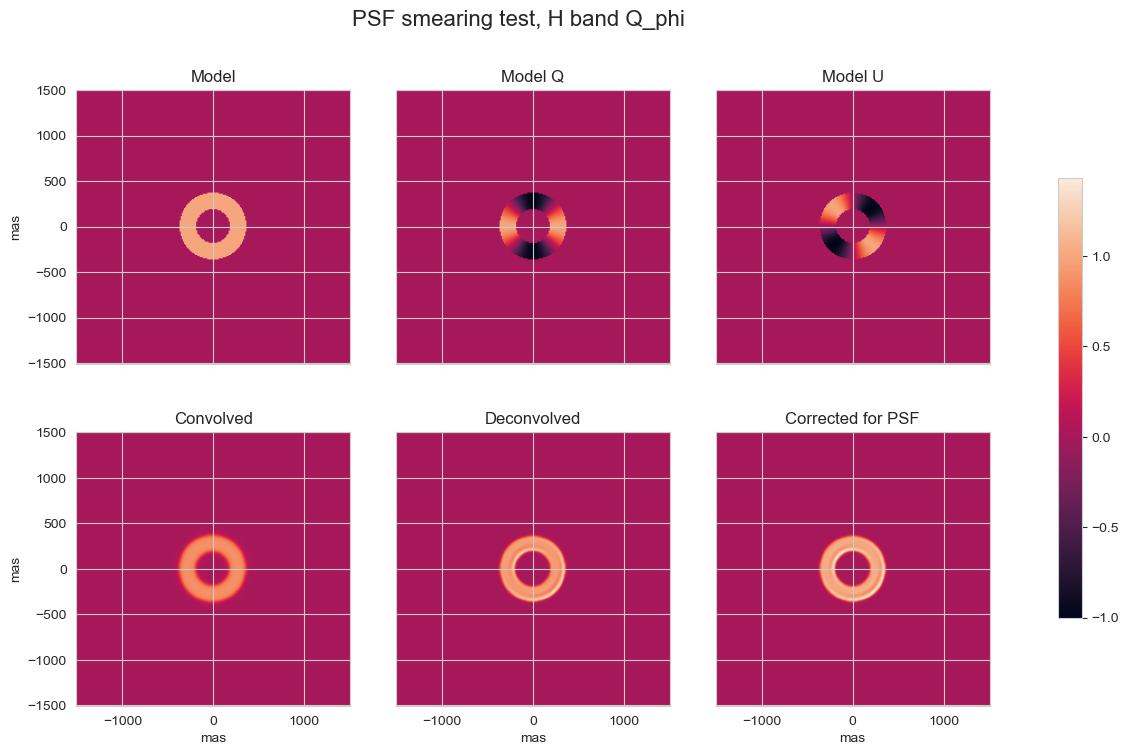

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.9180590378738223
Correction efficion  1.00344610967136
sum_PI
Signal after PSF convolution (as ratio to initial) 0.9191512584358617
PI corr  [[ 3.38501802e-20  6.10068929e-20 -5.39131705e-21 ... -8.50896926e-21
   1.88026370e-22  1.45255194e-23]
 [ 6.10901711e-18  3.88806347e-18  3.89297195e-19 ... -7.66689332e-22
   1.73479555e-23 -1.50947470e-24]
 [ 1.33031776e-17  9.80263905e-18  8.80935802e-19 ...  6.29174719e-20
  -3.78733233e-21 -3.01161729e-21]
 ...
 [ 1.21133886e-17  1.90217929e-17  2.90050669e-18 ...  6.88865050e-17
   3.39761505e-16  1.96585747e-16]
 [ 3.81225847e-18  4.04345809e-18  7.02912762e-19 ... -3.19307206e-17
   1.32342079e-16  2.14187153e-17]
 [ 7.55123819e-20  6.78947060e-20  7.38522628e-21 ... -5.48533328e-20
   4.38574659e-19  4.41905358e-21]]
Correction efficion  1.0028647636566097


In [61]:
if PDI == True:
    f_q= Loadimage(figfolder,band+'band_qphi_circular_f_psf_'+str(psf_cut)+'.fits')
    f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')

    n_model=1024
    shift=int((n_model)/2.)
    x = np.linspace(-shift+1, shift, num=n_model)
    y = np.linspace(-shift+1, shift, num=n_model)
    x=x-0.5
    y=y-0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    #calculating angle for azimuthal polarisation
    phi= np.arctan(Y/X)
    ring_H=np.zeros((1024,1024))

    ring_H[(R<=30)*(R>15)]=1
    ring_H_q=ring_H*np.cos(2*phi)
    ring_H_u=ring_H*np.sin(2*phi)

    lim=20

    qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
    uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot
    #[30,50,70,90]
    for psf_cut in [50]:
        print(psf_cut)
        #downloading PSF files
        # image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
        # psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # psf_H=psf_H_short#/np.sum(psf_H_short)

        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)

        for band in bands:
            print(band)
            if band=='I':
                ps=3.6
                psf=psf_I
            elif band=='V':
                ps=3.6
                psf=psf_V
            elif band=='H':
                ps=12.27
                psf=psf_H

            f_q= Loadimage(figfolder,band+'band_qphi_circular_f_psf_'+str(psf_cut)+'.fits')
            f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')


            Q_conv=convolve_fft(ring_H_q, psf, boundary='wrap')#, normalize_kernel=np.sum)
            U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)

            PI_conv=np.sqrt(Q_conv*Q_conv+U_conv*U_conv)

            Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
            # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16
            U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

            plt.imshow(Q_phi_conv, cmap='gray')
            plt.title("Q_phi_conv")
            plt.show()
            plt.imshow(U_phi_conv, cmap='gray')
            plt.title("U_phi_conv")
            plt.show()


            Q_phi_deconvolved, crit= deconvolving(Q_phi_conv, psf, 25)
            PI_deconvolved, crit= deconvolving(PI_conv, psf, 25)

            print(crit)

            Q_phi_corrected=Q_phi_deconvolved*f_q
            # f_pi[f_pi == inf] = 0
            PI_corrected=PI_deconvolved*f_pi

            keys=['orig','orig_q','orig_u',  'conv','decon','corr']
            labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for PSF'}
            data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
            if band=='H':
                cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
            else:
                cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            plot_with_same_color(data, keys, labels ,'Q_phi','PSF smearing test, '+band+ ' band',10*ps,False,cameras)

            print('sum_Qphi')
            print('Signal after PSF convolution (as ratio to initial)',np.sum(Q_phi_conv)/np.sum(ring_H))
            print('Correction efficion ', np.sum(Q_phi_corrected)/np.sum(ring_H))
            print('sum_PI')
            print('Signal after PSF convolution (as ratio to initial)',np.sum(PI_conv)/np.sum(ring_H))
            print('PI corr ', PI_corrected)
            print('Correction efficion ', np.nansum(PI_corrected)/np.nansum(ring_H))

            #print('sum_Qphi')
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(Q_phi_conv))
            #print('Corrected',np.sum(Q_phi_corrected))
            #print('sum_PI')
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(PI_conv))
            #print('Corrected',np.sum(PI_corrected))


In [62]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/'

In [63]:
if DI == True:
    f_i= Loadimage(figfolder,band+'band_i_circular_f_psf_'+str(psf_cut)+'.fits')
    # f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')

    n_model=1024
    shift=int((n_model)/2.)
    x = np.linspace(-shift+1, shift, num=n_model)
    y = np.linspace(-shift+1, shift, num=n_model)
    x=x-0.5
    y=y-0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    #calculating angle for azimuthal polarisation
    # phi= np.arctan(Y/X)
    ring_H=np.zeros((1024,1024))

    ring_H[(R<=30)*(R>15)]=1
    # ring_H_q=ring_H*np.cos(2*phi)
    # ring_H_u=ring_H*np.sin(2*phi)

    lim=20

    # qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
    # uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot
    #[30,50,70,90]
    for psf_cut in [50]:
        print(psf_cut)
        #downloading PSF files
        # image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
        # psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # psf_H=psf_H_short#/np.sum(psf_H_short)

        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/'
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)

        for band in bands:
            print(band)
            if band=='I':
                ps=3.6
                psf=psf_I
            elif band=='V':
                ps=3.6
                psf=psf_V
            elif band=='H':
                ps=12.27
                psf=psf_H

            f_i= Loadimage(figfolder,band+'band_i_circular_f_psf_'+str(psf_cut)+'.fits')
            # f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')

            I_conv=convolve_fft(ring_H, psf, boundary='wrap')#, normalize_kernel=np.sum)
            # U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)

            # PI_conv=np.sqrt(Q_conv*Q_conv+U_conv*U_conv)

            # Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
            # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16
            # U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

            plt.imshow(I_conv, cmap='gray')
            plt.title("I_conv")
            plt.show()
            # plt.imshow(U_phi_conv, cmap='gray')
            # plt.title("U_phi_conv")
            # plt.show()


            I_deconvolved, crit= deconvolving(I_conv, psf, 25)
            # PI_deconvolved, crit= deconvolving(PI_conv, psf, 25)

            print(crit)

            I_corrected=I_deconvolved*f_i
            # f_pi[f_pi == inf] = 0
            # PI_corrected=PI_deconvolved*f_pi

            keys=['orig', 'conv','decon','corr']
            labels={'orig':'Model','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for PSF'}
            data={'orig':ring_H, 'conv':I_conv,'decon':I_deconvolved,'corr':I_corrected}
            if band=='H':
                cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
            else:
                cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            plot_with_same_color(data, keys, labels ,'I','PSF smearing test, '+band+ ' band',10*ps,False,cameras)

            print('sum_I')
            print('Signal after PSF convolution (as ratio to initial)',np.sum(I_conv)/np.sum(ring_H))
            print('Correction efficion ', np.sum(I_corrected)/np.sum(ring_H))
            # print('sum_PI')
            # print('Signal after PSF convolution (as ratio to initial)',np.sum(PI_conv)/np.sum(ring_H))
            # print('PI corr ', PI_corrected)
            print('Correction efficion ', np.nansum(I_corrected)/np.nansum(ring_H))

            #print('sum_Qphi')
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(Q_phi_conv))
            #print('Corrected',np.sum(Q_phi_corrected))
            #print('sum_PI')
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(PI_conv))
            #print('Corrected',np.sum(PI_corrected))


In [64]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/'

In [65]:
check = PI_corrected.copy()

if np.any(np.isnan(check)):
    print("Warning: contains NaN values")
if np.any(np.isinf(check)):
    print("Warning: contains Inf values")
else:
    print("OK")

OK


In [66]:
plt.imshow(I_corrected, cmap='gray')
# colorbar()
# colorbar
# plt.xlim(-1000,1000)
# plt.ylim(-1000,1000)

NameError: name 'I_corrected' is not defined

In [67]:
I_corrected

NameError: name 'I_corrected' is not defined

In [68]:

inf_mask = np.isinf(f_pi)  # Create a boolean mask of inf values
print(inf_mask)  # Print the mask

# You can then use the mask to find the location of inf values:
inf_indices = np.where(inf_mask)
print(f"Indices of inf values: {inf_indices}")

# you can find the sum of all inf values with:
inf_sum = np.sum(inf_mask)
print(f"Number of inf values: {inf_sum}")

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Indices of inf values: (array([], dtype=int64), array([], dtype=int64))
Number of inf values: 0


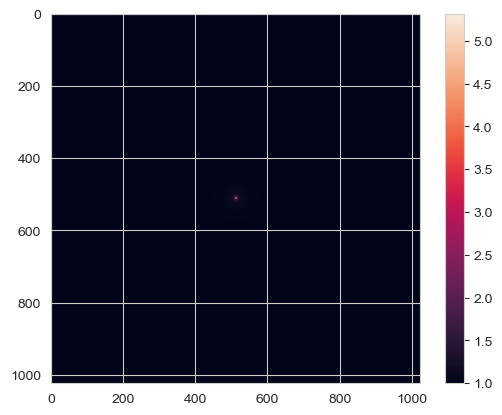

In [69]:
plt.imshow(f_pi)
plt.colorbar()  # Add the colorbar
plt.show()

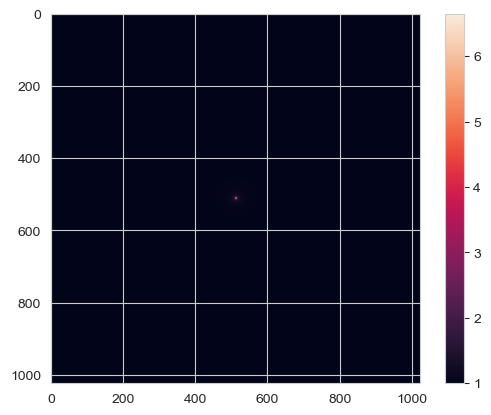

In [70]:
plt.imshow(f_q)
plt.colorbar()  # Add the colorbar
plt.show()

## Generating elliptical matrix of corrections

Works better than just circular

### Incl and PA from litr

50
4


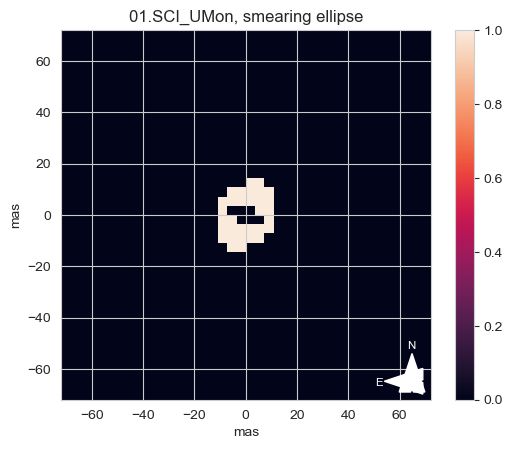

5


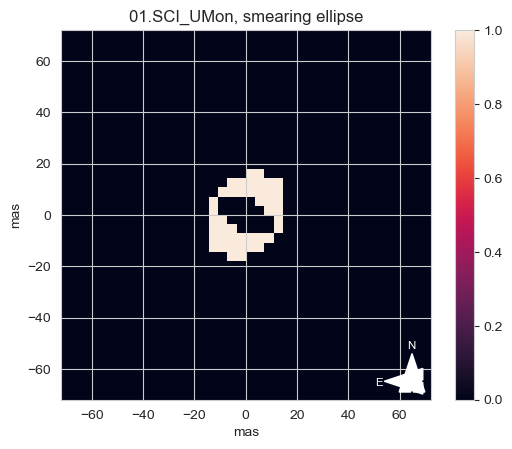

6


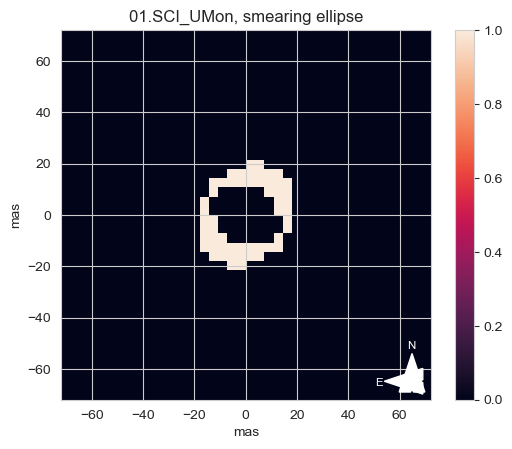

7


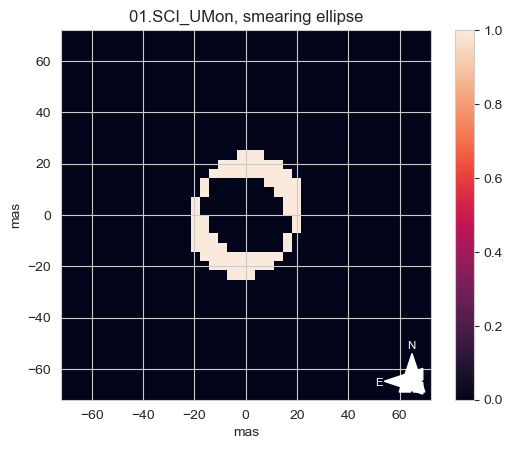

8


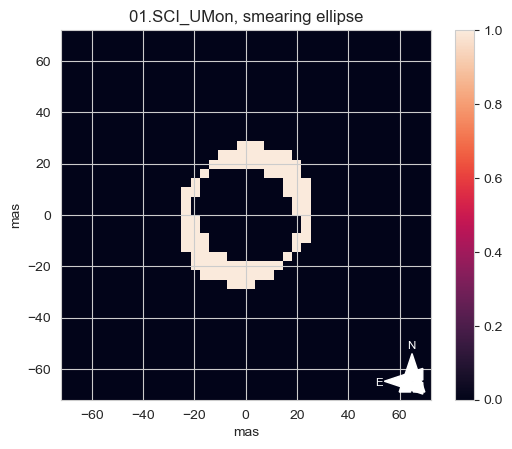

9


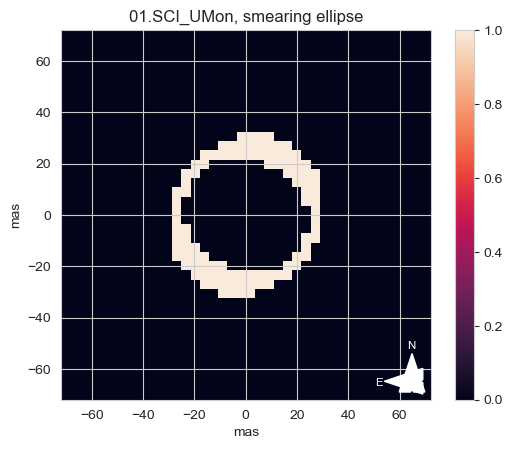

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [71]:
if PDI == True:
    # initialise
    f_pi_i=np.ones((1024,1024))
    f_pi_v=np.ones((1024,1024))
    f_pi_h=np.ones((1024,1024))
    f_q_i=np.ones((1024,1024))
    f_q_v=np.ones((1024,1024))
    f_q_h=np.ones((1024,1024))

    # create grid
    n_model=1024
    shift=int((n_model)/2.)
    x = np.linspace(-shift+1, shift, num=n_model)
    y = np.linspace(-shift+1, shift, num=n_model)
    x=x-0.5
    y=y-0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    #calculating angle for azimuthal polarisation
    phi= np.arctan(Y/X)

    dataframes={}
    disk_incl_pa={'01.SCI_AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
    sci_of_ref={'REF_HD75885':'01.SCI_AR_Pup','REF_HD71253':'UMon','01.SCI_UMon':'UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226','01.SCI_AR_Pup':'01.SCI_AR_Pup'} #the corresponding scientific targets, SPHERE proposals
    science_targ=sci_of_ref[star]
    incl_pa=disk_incl_pa[science_targ]                                              # define the disk inclination based on literature

     # define ellipse parameters
    center = (0, 0)                                                                 # center coordinates (x, y)
    position_angle = incl_pa[1]-90                                                  # position angle (orientation) of the ellipse (in degrees)
    sini=np.cos(np.deg2rad(incl_pa[0]))                                             # calculate sin(inclination), or height, of disk

    #[30,40,50,60,70,80,90,100,150,200]
    for psf_cut in [50]:
        print(psf_cut)
        #downloading PSF files (IRDIS)
        if star=='01.SCI_UMon' or star=='HD96314':
            image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
            psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
            psf_H=psf_H_short#/np.sum(psf_H_short)

        # load data
        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        # crop image
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # normalise data (optional)
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)

        # create data frame
        df = pd.DataFrame(columns=['majaxis_pix','majaxis_H', 'sum_Qphi_H','sum_Uphi_H','f_H','majaxis_V',  'sum_Qphi_V','sum_Uphi_V','f_V',
                                  'majaxis_I','sum_Qphi_I','sum_Uphi_I','f_I'])
        index=-1

        # for a range of lengths for the major axis
        for maxis in range(4,200,1):
            print(maxis)
            df.empty
            index=index+1
            # to obtain a real (non-zero, negative) length for minor axis, define angle > 1
            if int((maxis)*sini)<1:
                minaxis=1
            else:
                minaxis=int((maxis)*sini)

            # define the rest of ellipse parameters
            axes = (maxis, minaxis)  # Major and minor axis lengths

            # create an empty array for the ellipse
            ellipse_ring = np.zeros((n_model, n_model))
            # calculate the ellipse mask with the specified position angle
            a = np.deg2rad(position_angle)
            cos_a = np.cos(a)
            sin_a = np.sin(a)

            # Generate the ellipse mask with rotation
            mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

            # set the pixels inside the ellipse to 1
            ellipse_ring[mask] = 1

            if int((maxis-1)*sini)>1:                               # this correction is to avoid when we have just a few pixels for high inclined "ring"
                if minaxis-int((maxis-1)*sini)>=1:
                    minaxis=int((maxis-1)*sini)
                else: minaxis=minaxis-1

                axes = (maxis-3, minaxis)  # major and minor axis lengths
                # generate the ellipse mask with rotation
                mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
                # set the pixels inside the ellipse to 1
                ellipse_ring[mask] = 0

            df.loc[index,'majaxis_pix']=maxis

            ellipse_ring_q=ellipse_ring*np.cos(2*phi)
            ellipse_ring_u=ellipse_ring*np.sin(2*phi)

            lim=20

            qphi=(ellipse_ring_q*np.cos(2*phi)+ellipse_ring_u*np.sin(2*phi))#/model_imageItot

            # plot ellipse for small ring (mas/pixel)
            if maxis<10:
                image = qphi*(R<250)
                fig, ax = plt.subplots()
                f.plottingroutinemas(image,lim,3.6,image.shape[0],star,ax)
                f.scale_mas(star,ax)
                plt.title(star+', smearing ellipse')
                plt.savefig(figfolder+star+'_'+'_smearing_ellipse.jpeg',bbox_inches='tight', pad_inches=0.1)
                plt.show()
                plt.close()

            # calculate U_phi
            uphi=(ellipse_ring_q*np.sin(2*phi)-ellipse_ring_u*np.cos(2*phi))#/model_imageItot

            for band in bands:
                if band=='I':
                    ps=3.6
                    psf=psf_I
                elif band=='V':
                    ps=3.6
                    psf=psf_V
                elif band=='H':
                    ps=12.27
                    psf=psf_H

                # convolve Q and U stokes
                Q_conv=convolve_fft(ellipse_ring_q, psf, boundary='wrap')#, normalize_kernel=np.sum)
                U_conv=convolve_fft(ellipse_ring_u, psf, boundary='wrap')#, normalize_kernel=np.sum)

                # convolve Q_phi and U_phi stokes
                Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
                # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16 #to clearly simulate analysis situation and look only on the azimuthal part
                U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

                #print('Q_phi',np.sum(Q_phi_conv))

                df.loc[index,'sum_Qphi_'+band]=np.sum(Q_phi_conv)
                df.loc[index,'majaxis_'+band]=maxis*ps

                df.loc[index,'sum_Uphi_'+band]=np.sum(U_phi_conv)
                df.loc[index,'f_'+band]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                dataframes[f'df_{psf_cut}'] = df

                # mask the image (ellipse)
                if band=='I':
                    f_q_i[(ellipse_ring*f_q_i)==1]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                    f_pi_i[(ellipse_ring*f_pi_i)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='V':
                    f_q_v[(ellipse_ring*f_q_v)==1]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                    f_pi_v[(ellipse_ring*f_pi_v)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='H':
                    f_q_h[(ellipse_ring*f_q_h)==1]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                    f_pi_h[(ellipse_ring*f_pi_h)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))

        df.to_csv(figfolder+star+'ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+f'df_{psf_cut}'+'.csv')
        out_fits = fits.HDUList(fits.PrimaryHDU(f_q_i))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Iband_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

        out_fits = fits.HDUList(fits.PrimaryHDU(f_q_v))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Vband_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        if star=='01.SCI_UMon' or star=='HD96314':
            out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))                  # create output fits structure
            out_fits.writeto(figfolder+star+'Hband_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

        out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_i))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Iband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

        out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_v))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Vband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        if star=='01.SCI_UMon' or star=='HD96314':
            out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_h))                  # create output fits structure
            out_fits.writeto(figfolder+star+'Hband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

In [72]:
if DI == True:
    # initialise
    f_i_i=np.ones((1024,1024))
    f_i_v=np.ones((1024,1024))
    # f_pi_h=np.ones((1024,1024))
    # f_q_i=np.ones((1024,1024))
    # f_q_v=np.ones((1024,1024))
    # f_q_h=np.ones((1024,1024))

    # create grid
    n_model=1024
    shift=int((n_model)/2.)
    x = np.linspace(-shift+1, shift, num=n_model)
    y = np.linspace(-shift+1, shift, num=n_model)
    x=x-0.5
    y=y-0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    #calculating angle for azimuthal polarisation
    phi= np.arctan(Y/X)

    dataframes={}
    disk_incl_pa={'AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
    sci_of_ref={'02.SCI_AR_Pup':'AR_Pup','REF_HD75885':'AR_Pup','REF_HD71253':'UMon','01.SCI_UMon':'UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226'} #the corresponding scientific targets, SPHERE proposals
    science_targ=sci_of_ref[star]
    incl_pa=disk_incl_pa[science_targ]                                              # define the disk inclination based on literature

     # define ellipse parameters
    center = (0, 0)                                                                 # center coordinates (x, y)
    position_angle = incl_pa[1]-90                                                  # position angle (orientation) of the ellipse (in degrees)
    sini=np.cos(np.deg2rad(incl_pa[0]))                                             # calculate sin(inclination), or height, of disk

    #[30,40,50,60,70,80,90,100,150,200]
    for psf_cut in [50]:
        print(psf_cut)
        #downloading PSF files (IRDIS)
        if star=='01.SCI_UMon' or star=='HD96314':
            image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
            psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
            psf_H=psf_H_short#/np.sum(psf_H_short)

        # load data
        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/'
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        # crop image
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        # normalise data (optional)
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)

        # create data frame
        df = pd.DataFrame(columns=['majaxis_pix','majaxis_H', 'sum_I_H','f_H','majaxis_V', 'sum_I_V','f_V',
                                  'majaxis_I','sum_I_I','f_I'])
        index=-1

        # for a range of lengths for the major axis
        for maxis in range(4,200,1):
            print(maxis)
            df.empty
            index=index+1
            # to obtain a real (non-zero, negative) length for minor axis, define angle > 1
            if int((maxis)*sini)<1:
                minaxis=1
            else:
                minaxis=int((maxis)*sini)

            # define the rest of ellipse parameters
            axes = (maxis, minaxis)  # Major and minor axis lengths

            # create an empty array for the ellipse
            ellipse_ring = np.zeros((n_model, n_model))
            # calculate the ellipse mask with the specified position angle
            a = np.deg2rad(position_angle)
            cos_a = np.cos(a)
            sin_a = np.sin(a)

            # Generate the ellipse mask with rotation
            mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

            # set the pixels inside the ellipse to 1
            ellipse_ring[mask] = 1

            if int((maxis-1)*sini)>1:                               # this correction is to avoid when we have just a few pixels for high inclined "ring"
                if minaxis-int((maxis-1)*sini)>=1:
                    minaxis=int((maxis-1)*sini)
                else: minaxis=minaxis-1

                axes = (maxis-3, minaxis)  # major and minor axis lengths
                # generate the ellipse mask with rotation
                mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
                # set the pixels inside the ellipse to 1
                ellipse_ring[mask] = 0

            df.loc[index,'majaxis_pix']=maxis

            ellipse_ring_i=ellipse_ring*np.cos(2*phi)
            # ellipse_ring_u=ellipse_ring*np.sin(2*phi)

            lim=20

            qphi=(ellipse_ring_i*np.cos(2*phi))#/model_imageItot

            # plot ellipse for small ring (mas/pixel)
            if maxis<10:
                image = qphi*(R<250)
                fig, ax = plt.subplots()
                f.plottingroutinemas(image,lim,3.6,image.shape[0],star,ax)
                f.scale_mas(star,ax)
                plt.title(star+', smearing ellipse')
                plt.savefig(figfolder+star+'_'+'_smearing_ellipse.jpeg',bbox_inches='tight', pad_inches=0.1)
                plt.show()
                plt.close()

            # calculate U_phi
            # uphi=(ellipse_ring_q*np.sin(2*phi)-ellipse_ring_u*np.cos(2*phi))#/model_imageItot

            for band in bands:
                if band=='I':
                    ps=3.6
                    psf=psf_I
                elif band=='V':
                    ps=3.6
                    psf=psf_V
                elif band=='H':
                    ps=12.27
                    psf=psf_H

                # convolve Q and U stokes
                I_conv=convolve_fft(ellipse_ring_i, psf, boundary='wrap')#, normalize_kernel=np.sum)
                # U_conv=convolve_fft(ellipse_ring_u, psf, boundary='wrap')#, normalize_kernel=np.sum)

                # convolve Q_phi and U_phi stokes
                # Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
                # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16 #to clearly simulate analysis situation and look only on the azimuthal part
                # U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

                #print('Q_phi',np.sum(Q_phi_conv))

                df.loc[index,'sum_I_'+band]=np.sum(I_conv)
                df.loc[index,'majaxis_'+band]=maxis*ps

                # df.loc[index,'sum_Uphi_'+band]=np.sum(U_phi_conv)
                df.loc[index,'f_'+band]=np.sum(ellipse_ring)/np.sum(I_conv)
                dataframes[f'df_{psf_cut}'] = df

                # mask the image (ellipse)
                if band=='I':
                    f_i_i[(ellipse_ring*f_i_i)==1]=np.sum(ellipse_ring)/np.sum(I_conv)
                    # f_pi_i[(ellipse_ring*f_pi_i)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='V':
                    f_i_v[(ellipse_ring*f_i_v)==1]=np.sum(ellipse_ring)/np.sum(I_conv)
                    # f_pi_v[(ellipse_ring*f_pi_v)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
                elif band=='H':
                    f_i_h[(ellipse_ring*f_i_h)==1]=np.sum(ellipse_ring)/np.sum(I_conv)
                    # f_pi_h[(ellipse_ring*f_pi_h)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))

        df.to_csv(figfolder+star+'ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+f'df_{psf_cut}'+'.csv')
        out_fits = fits.HDUList(fits.PrimaryHDU(f_i_i))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Iband_I_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

        out_fits = fits.HDUList(fits.PrimaryHDU(f_i_v))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Vband_I_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        if star=='01.SCI_UMon' or star=='HD96314':
            out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))                  # create output fits structure
            out_fits.writeto(figfolder+star+'Hband_I_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

        # out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_i))                  # create output fits structure
        # out_fits.writeto(figfolder+star+'Iband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        #
        # out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_v))                  # create output fits structure
        # out_fits.writeto(figfolder+star+'Vband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
        # if star=='01.SCI_UMon' or star=='HD96314':
        #     out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_h))                  # create output fits structure
        #     out_fits.writeto(figfolder+star+'Hband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

In [73]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/'

### Test with the ellipse with same PA and i

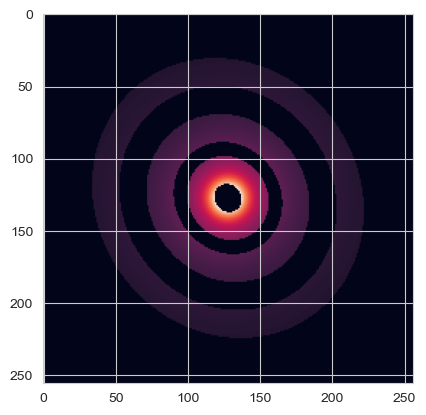

50
V
256
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
8
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
9
0.0134390431074299
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/models/  already exists


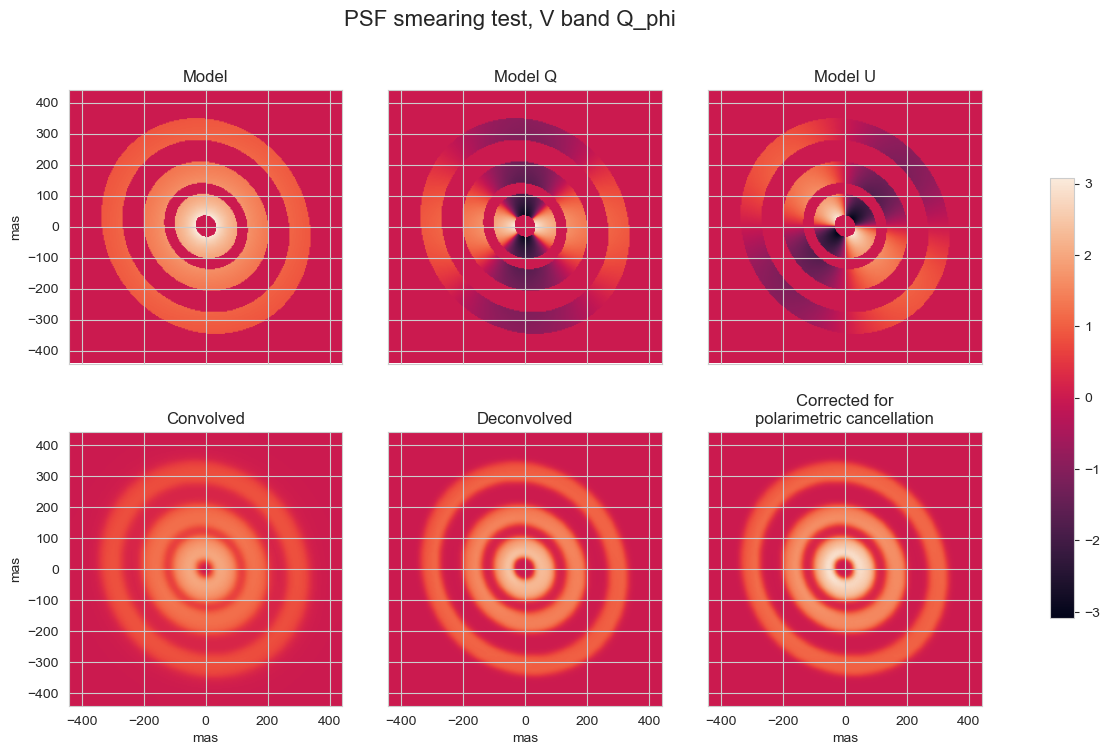

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.8188558026386238
Signal after deconvolution (as ratio to initial) 0.8195561160507943
Signal after PSF correction 1.0021699966272055
sum_PI
Signal after PSF convolution (as ratio to initial) 0.8200775526340498
Signal after PSF correction  0.9984355019891006
I
256
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
9
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
9
0.014670471852090755
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/PSF_models/models/  already exists


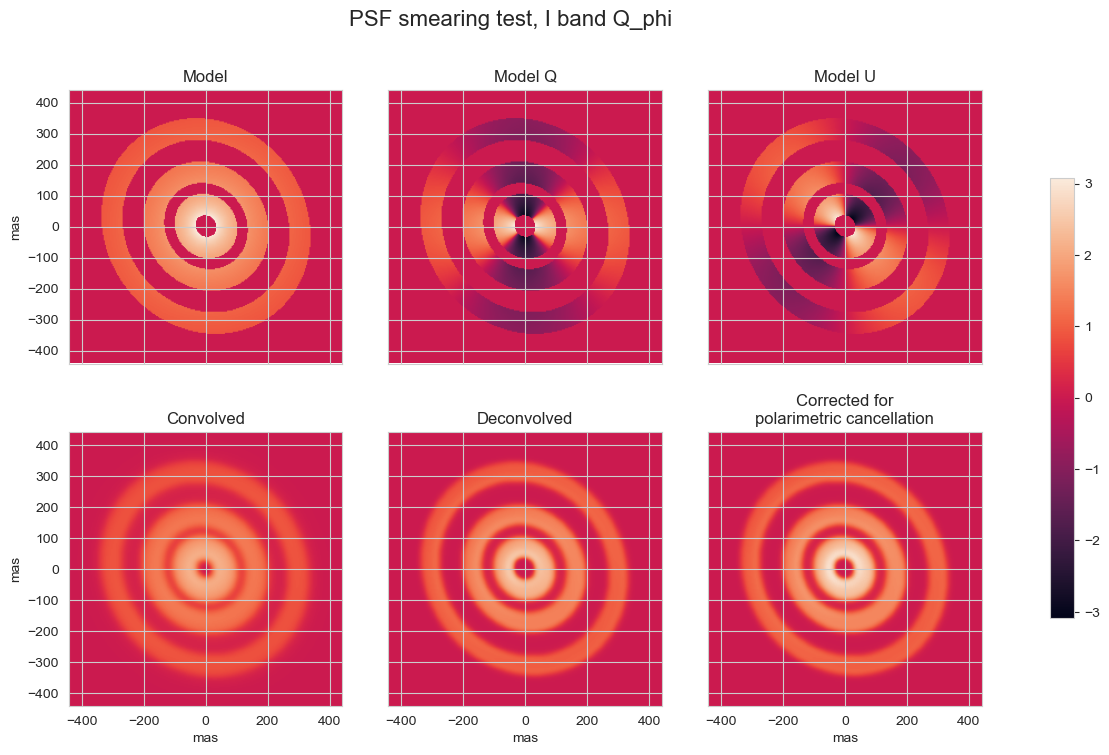

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.8692098272408235
Signal after deconvolution (as ratio to initial) 0.8699225814383666
Signal after PSF correction 0.999797152905857
sum_PI
Signal after PSF convolution (as ratio to initial) 0.8701314959731767
Signal after PSF correction  0.9986071064354686
H
256
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 14
deconvolution step 15
15
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 14
deconvoluti

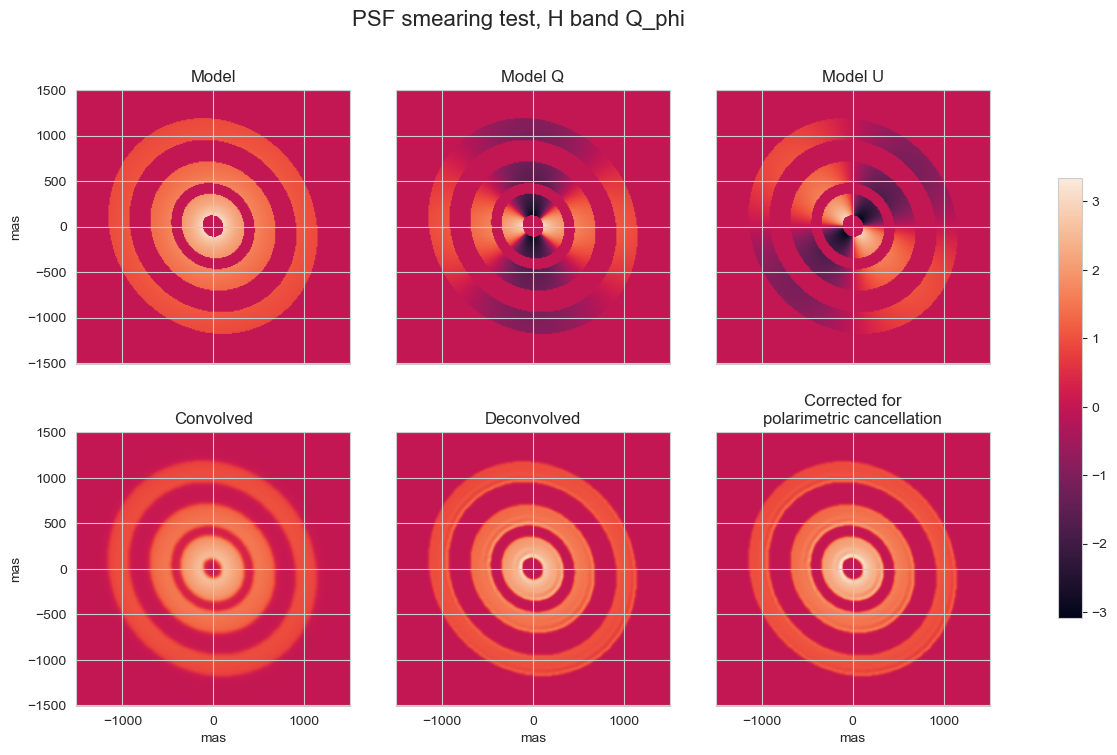

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.9496929672905845
Signal after deconvolution (as ratio to initial) 0.9513403561015611
Signal after PSF correction 1.0018923866308724
sum_PI
Signal after PSF convolution (as ratio to initial) 0.9503337881089102
Signal after PSF correction  1.0014090773583815


In [74]:
if PDI == True:

    import numpy as np
    import matplotlib.pyplot as plt

    n_model = 256
    shift = int(n_model / 2)
    x = np.linspace(-shift + 1, shift, num=n_model)
    y = np.linspace(-shift + 1, shift, num=n_model)
    x = x - 0.5
    y = y - 0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    #calculating angle for azimuthal polarisation
    phi= np.arctan(Y/X)
    science_targ=sci_of_ref[star]
    incl_pa=disk_incl_pa[science_targ]

     # Define ellipse parameters
    center = (0, 0)  # Center coordinates (x, y)

    position_angle = incl_pa[1]-90  # Position angle (orientation) of the ellipse (in degrees)
    sini=np.cos(np.deg2rad(incl_pa[0]))

    # Create an empty array for the ellipse
    ellipse_ring = np.zeros((n_model, n_model))
    ellipse_ring=100/R
    # Calculate the ellipse mask with the specified position angle
    a = np.deg2rad(position_angle)
    cos_a = np.cos(a)
    sin_a = np.sin(a)

    axes = (100, 100*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
    # Set the pixels inside the ellipse to 1
    ellipse_ring[~mask] = 0

    axes = (80, 80*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask1 = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # Set the pixels inside the ellipse to 1

    axes = (60, 60*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    mask = mask1 & ~mask2
    # Set the pixels inside the ellipse to 1
    ellipse_ring[mask] = 0



    axes = (40, 40*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask1 = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # Set the pixels inside the ellipse to 1

    axes = (30, 30*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    mask = mask1 & ~mask2
    # Set the pixels inside the ellipse to 1
    ellipse_ring[mask] = 0

    axes = (30-20, (30-20)*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # Set the pixels inside the ellipse to 1
    ellipse_ring[mask] = 0


    # axes = (100, 100*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 40

    # axes = (80, 80*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0

    # axes = (60, 60*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 45

    # axes = (40, (40)*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0

    # axes = (30, 30*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 50

    # axes = (30-20, (30-20)*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0


    # axes = (100, 100*np.cos(np.deg2rad(75)))  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 1

    # axes = (80, 80*np.cos(np.deg2rad(75)))  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0

    # axes = (30, 30*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 5


    # axes = (30-10, 30*sini-10)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0




    # Display the ellipse
    plt.imshow(ellipse_ring)
    plt.show()
    plt.close()

    ring_H=ellipse_ring

    ring_H_q=ring_H*np.cos(2*phi)
    ring_H_u=ring_H*np.sin(2*phi)

    lim=20

    qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
    uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot

    for psf_cut in [50]:
        print(psf_cut)
        #downloading PSF files
        if star=='01.SCI_UMon' or star=='HD96314':
            image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
            psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
            psf_H=psf_H_short#/np.sum(psf_H_short)

        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)



        for band in bands:
            print(band)
            if band=='I':
                ps=3.6
                psf=psf_I

            elif band=='V':
                ps=3.6
                psf=psf_V

            elif band=='H':
                ps=12.27
                psf=psf_H

            f_q= Loadimage(figfolder,band+'band_qphi_circular_f_psf_'+str(psf_cut)+'.fits')
            f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')

            # f_q= Loadimage(figfolder,star+band+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits')
            # f_pi= Loadimage(figfolder,star+band+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits')
            f_q=f_q[512-128:512+128,512-128:512+128]
            print(f_q.shape[0])
            f_pi=f_pi[512-128:512+128,512-128:512+128]

            Q_conv=convolve_fft(ring_H_q, psf, boundary='wrap')
            U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)
            PI_conv=np.sqrt(Q_conv*Q_conv+U_conv*U_conv)

            Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
            # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16 #to clearly simulate analysis situation and look only on the azimuthal part
            U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

            PI_deconvolved, crit= deconvolving(PI_conv, psf, 25)

            PI_corrected=PI_deconvolved*f_pi

            Q_phi_deconvolved, crit= deconvolving(Q_phi_conv, psf, 25)
            print(crit)

            Q_phi_corrected=Q_phi_deconvolved*f_q
            #to see Q and U
            #keys=['orig','orig_q','orig_u',  'conv','decon','corr']
            #labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for PSF'}
            #data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
            #if band=='H':
            #    cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
            #else:
            #    cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            #without Q and U
            keys=['orig',  'conv','decon','corr']
            labels={'orig':'Model','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for polarimetric cancellation'}
            data={'orig':ring_H, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
            if band=='H':
                cameras=['IRDIS','IRDIS','IRDIS','IRDIS']
            else:
                cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            keys=['orig','orig_q','orig_u',  'conv','decon','corr']
            labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for polarimetric cancellation'}
            data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
            if band=='H':
                cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
            else:
                cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            plot_with_same_color(data, keys, labels ,'Q_phi','PSF smearing test, '+band+ ' band',10*ps,True,cameras)

            #print('Q_phi',np.sum(Q_phi_conv))
            print('sum_Qphi')
            print('Signal after PSF convolution (as ratio to initial)',np.sum(Q_phi_conv)/np.sum(ring_H))
            print('Signal after deconvolution (as ratio to initial)',np.sum(Q_phi_deconvolved)/np.sum(ring_H))
            print('Signal after PSF correction', np.sum(Q_phi_corrected)/np.sum(ring_H))

            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(Q_phi_conv))
            #print('Corrected',np.sum(Q_phi_corrected))
            print('sum_PI')
            print('Signal after PSF convolution (as ratio to initial)',np.sum(PI_conv)/np.sum(ring_H))
            print('Signal after PSF correction ', np.sum(PI_corrected)/np.sum(ring_H))
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(PI_conv))
            #print('Corrected',np.sum(PI_corrected))



In [75]:
if DI == True:

    import numpy as np
    import matplotlib.pyplot as plt

    n_model = 256
    shift = int(n_model / 2)
    x = np.linspace(-shift + 1, shift, num=n_model)
    y = np.linspace(-shift + 1, shift, num=n_model)
    x = x - 0.5
    y = y - 0.5

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    #calculating angle for azimuthal polarisation
    phi= np.arctan(Y/X)
    science_targ=sci_of_ref[star]
    incl_pa=disk_incl_pa[science_targ]

     # Define ellipse parameters
    center = (0, 0)  # Center coordinates (x, y)

    position_angle = incl_pa[1]-90  # Position angle (orientation) of the ellipse (in degrees)
    sini=np.cos(np.deg2rad(incl_pa[0]))

    # Create an empty array for the ellipse
    ellipse_ring = np.zeros((n_model, n_model))
    ellipse_ring=100/R
    # Calculate the ellipse mask with the specified position angle
    a = np.deg2rad(position_angle)
    cos_a = np.cos(a)
    sin_a = np.sin(a)

    axes = (100, 100*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
    # Set the pixels inside the ellipse to 1
    ellipse_ring[~mask] = 0

    axes = (80, 80*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask1 = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # Set the pixels inside the ellipse to 1

    axes = (60, 60*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    mask = mask1 & ~mask2
    # Set the pixels inside the ellipse to 1
    ellipse_ring[mask] = 0


    axes = (40, 40*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask1 = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # Set the pixels inside the ellipse to 1

    axes = (30, 30*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    mask = mask1 & ~mask2
    # Set the pixels inside the ellipse to 1
    ellipse_ring[mask] = 0

    axes = (30-20, (30-20)*sini)  # Major and minor axis lengths
    # Generate the ellipse mask with rotation
    mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # Set the pixels inside the ellipse to 1
    ellipse_ring[mask] = 0


    # axes = (100, 100*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 40

    # axes = (80, 80*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0

    # axes = (60, 60*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 45

    # axes = (40, (40)*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0

    # axes = (30, 30*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 50

    # axes = (30-20, (30-20)*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0


    # axes = (100, 100*np.cos(np.deg2rad(75)))  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 1

    # axes = (80, 80*np.cos(np.deg2rad(75)))  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0

    # axes = (30, 30*sini)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 5


    # axes = (30-10, 30*sini-10)  # Major and minor axis lengths
    # # Generate the ellipse mask with rotation
    # mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
    # # Set the pixels inside the ellipse to 1
    # ellipse_ring[mask] = 0


    # Display the ellipse
    plt.imshow(ellipse_ring)
    plt.show()
    plt.close()

    ring_H=ellipse_ring

    lim=20

    for psf_cut in [50]:
        print(psf_cut)
        #downloading PSF files
        if star=='01.SCI_UMon' or star=='HD96314':
            image_sphere, psf_H, n,hdul= Loadimages(star,'Q_phi')
            psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
            psf_H=psf_H_short#/np.sum(psf_H_short)

        figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/'
        psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
        psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')
        psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_V=psf_V_short#/np.sum(psf_V_short)
        psf_I=psf_I_short#/np.sum(psf_I_short)



        for band in bands:
            print(band)
            if band=='I':
                ps=3.6
                psf=psf_I

            elif band=='V':
                ps=3.6
                psf=psf_V

            elif band=='H':
                ps=12.27
                psf=psf_H

            f_i= Loadimage(figfolder,band+'band_i_circular_f_psf_'+str(psf_cut)+'.fits')
            # f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')

            # f_q= Loadimage(figfolder,star+band+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits')
            # f_pi= Loadimage(figfolder,star+band+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits')
            f_i=f_i[512-128:512+128,512-128:512+128]
            print(f_i.shape[0])

            I_conv=convolve_fft(ring_H, psf, boundary='wrap')
            # U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)
            # PI_conv=np.sqrt(Q_conv*Q_conv+U_conv*U_conv)

            # Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
            # Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16 #to clearly simulate analysis situation and look only on the azimuthal part
            # U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

            I_deconvolved, crit= deconvolving(I_conv, psf, 25)

            I_corrected=I_deconvolved*f_i

            # I_deconvolved, crit= deconvolving(Q_phi_conv, psf, 25)
            print(crit)

            # Q_phi_corrected=Q_phi_deconvolved*f_q
            #to see Q and U
            #keys=['orig','orig_q','orig_u',  'conv','decon','corr']
            #labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for PSF'}
            #data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
            #if band=='H':
            #    cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
            #else:
            #    cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            #without Q and U
            keys=['orig',  'conv','decon','corr']
            labels={'orig':'Model','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for polarimetric cancellation'}
            data={'orig':ring_H, 'conv':I_conv,'decon':I_deconvolved,'corr':I_corrected}
            if band=='H':
                cameras=['IRDIS','IRDIS','IRDIS','IRDIS']
            else:
                cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']

            #
            # keys=['orig','orig_q','orig_u',  'conv','decon','corr']
            # labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for polarimetric cancellation'}
            # data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
            # if band=='H':
            #     cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
            # else:
            #     cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']


            plot_with_same_color(data, keys, labels ,'I','PSF smearing test, '+band+ ' band',10*ps,True,cameras)

            #print('Q_phi',np.sum(Q_phi_conv))
            print('sum_I')
            print('Signal after PSF convolution (as ratio to initial)',np.sum(I_conv)/np.sum(ring_H))
            print('Signal after deconvolution (as ratio to initial)',np.sum(I_deconvolved)/np.sum(ring_H))
            print('Signal after PSF correction', np.sum(I_corrected)/np.sum(ring_H))
            #
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(Q_phi_conv))
            #print('Corrected',np.sum(Q_phi_corrected))
            # print('sum_PI')
            # print('Signal after PSF convolution (as ratio to initial)',np.sum(PI_conv)/np.sum(ring_H))
            # print('Signal after PSF correction ', np.sum(PI_corrected)/np.sum(ring_H))
            #print('Initial ', np.sum(ring_H))
            #print('Convolved',np.sum(PI_conv))
            #print('Corrected',np.sum(PI_corrected))



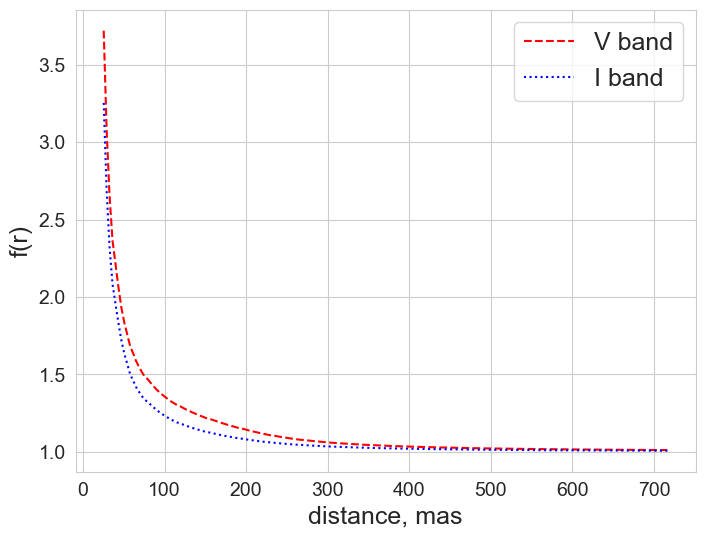

In [76]:

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
imagefolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_correction_plot/'
createfolder(imagefolder)

df_a_circ = pd.read_csv(figfolder+f'df_{psf_cut}'+'.csv')

df_a = pd.read_csv(figfolder+star+'ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'df_50'+'.csv')
fig = plt.figure(figsize=(8, 6))

# plt.plot(df_a['majaxis_H'],df_a['f_H'],label='H band',color='black')
plt.plot(df_a['majaxis_V'][3:],df_a['f_V'][3:],label='V band',color='red',linestyle='dashed')
plt.plot(df_a['majaxis_I'][3:],df_a['f_I'][3:],label='I band',color='blue',linestyle='dotted')
# plt.plot(df_a_circ['radius_V'][3:],df_a_circ['f_V'][3:],label='V circ',color='black',linestyle='dashed')
# plt.plot(df_a_circ['radius_I'][3:],df_a_circ['f_I'][3:],label='I circ',color='black',linestyle='dotted')
# #plt.title('Andrych')
# plt.ylim(0,5.5)
# plt.xlim(0,750)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('distance, mas', fontsize=18)
plt.ylabel('f(r)', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(imagefolder+star+'_smearing_coeff.png')
plt.show()
plt.close()


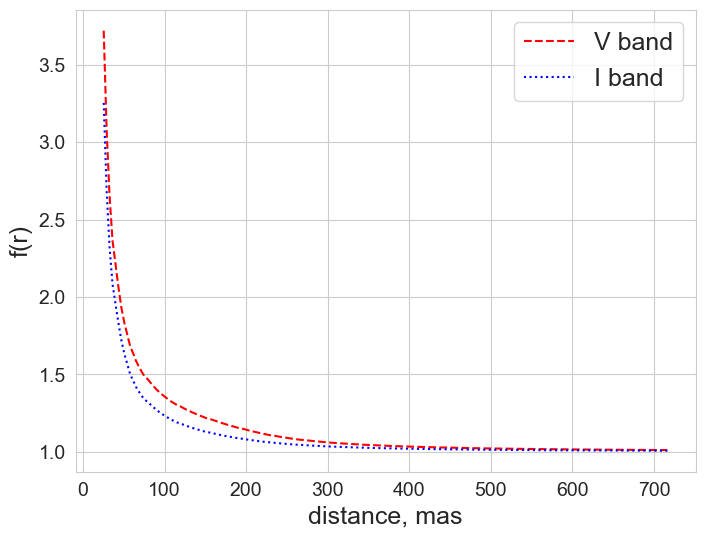

In [77]:

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")


imagefolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_correction_plot/'
createfolder(imagefolder)

df_a_circ = pd.read_csv(figfolder+f'df_{psf_cut}'+'.csv')

df_a = pd.read_csv(figfolder+star+'ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'df_50'+'.csv')
fig = plt.figure(figsize=(8, 6))

# plt.plot(df_a['majaxis_H'],df_a['f_H'],label='H band',color='black')
plt.plot(df_a['majaxis_V'][3:],df_a['f_V'][3:],label='V band',color='red',linestyle='dashed')
plt.plot(df_a['majaxis_I'][3:],df_a['f_I'][3:],label='I band',color='blue',linestyle='dotted')
# plt.plot(df_a_circ['radius_V'][3:],df_a_circ['f_V'][3:],label='V circ',color='black',linestyle='dashed')
# plt.plot(df_a_circ['radius_I'][3:],df_a_circ['f_I'][3:],label='I circ',color='black',linestyle='dotted')
# #plt.title('Andrych')
# plt.ylim(0,5.5)
# plt.xlim(0,750)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('distance, mas', fontsize=18)
plt.ylabel('f(r)', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(imagefolder+star+'_smearing_coeff.png')
plt.show()
plt.close()
